In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mounted_path = "drive/MyDrive/Thesis/"

### Get the roads of the city

We use OSMnx to retrieve the road network of the selected city and save the result as a GeoPackage file.

In [ ]:
# Install osmnx
%pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the necessary libraries to get the coordinates from the city
import osmnx as ox

In [ ]:
# Get the roadnetwork of a specific city using OpenStreetMap data
city = "Kampala, Uganda"

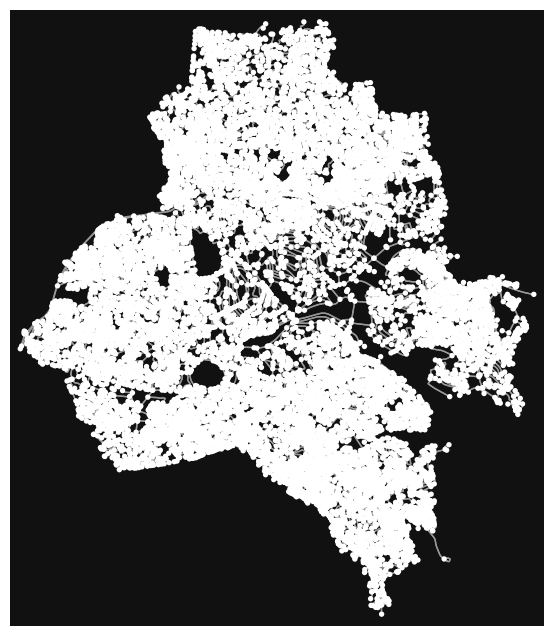

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
# Get the road network graph using OpenStreetMap data
# 'network_type' argument is set to 'drive' to get the road network suitable for driving
# 'simplify' argument is set to 'True' to simplify the road network
G = ox.graph_from_place(city, network_type="drive", simplify=True)

# Plot the road network graph using osmnx
ox.plot_graph(G)

In [ ]:
# Project the graph from latitude-longitude coordinates to a local projection (in meters)
G_proj = ox.project_graph(G)

# Save the projected graph to a GeoPackage file
ox.save_graph_geopackage(G_proj, filepath="{}data/{}/{} road.gpkg".format(mounted_path, city, city))

### Get the road edges and select the points

The previously saved GeoPackage file with the road network data is read to then create a list of points over the road map with a defined distance between them.

In [ ]:
# Import GeoPandas library to read and manipulate vector geospatial data
import geopandas as gpd

In [ ]:
# Load the saved GeoPackage file containing the road network graph
path_to_file="{}data/{}/{} road.gpkg".format(mounted_path, city, city)
gdf = gpd.read_file(path_to_file, layer="edges")

In [ ]:
# Get a list of points over the road map with a N distance between them

# Define the distance between points that we want
distance = 50

# Initialize a list to store the points
points = []

# Loop through each road in the road network graph
for road in gdf.geometry:
    # Calculate the total length of the road
    road_length = road.length

    # Start at the beginning of the road
    current_position = 0

    # Loop through the road, adding points every 50 meters
    while current_position < road_length:
        # Get the point on the road at the current position
        current_point = road.interpolate(current_position)

        # Add the curent point to the list of points
        points.append(current_point)

        # Increment the position by the desired distance
        current_position += distance

In [ ]:
# Convert the list of points to a GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=points)

# Set the same CRS as the road dataframes for the points dataframe
gdf_points.set_crs(gdf.crs, inplace=True)

,geometry
0,POINT (455163.487 37512.614)
1,POINT (455172.312 37521.545)
2,POINT (455216.100 37497.409)
3,POINT (455260.022 37473.516)
4,POINT (455303.839 37449.434)
...,...
49349,POINT (455704.725 40450.895)
49350,POINT (455745.498 40458.253)
49351,POINT (455699.053 40522.245)
49352,POINT (455733.407 40504.350)


In [ ]:
# Save the points GeoDataFrame to a GeoPackage file
path_to_file="{}data/{}/{} points.gpkg".format(mounted_path, city, city)
gdf_points.to_file(path_to_file, driver="GPKG", crs=gdf_points.crs)

### Get the features on the selected points on the roads

Here, we group the points by their corresponding tiles and download the tiles and extract the features for each group. Then, the features are mateched to each point and the results are saved as a GeoPackage file.

In [ ]:
%pip install vt2geojson
%pip install mercantile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 37.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import the necessary libraries to get the images
from vt2geojson.tools import vt_bytes_to_geojson
from shapely.geometry import Point
from scipy.spatial import cKDTree
import geopandas as gpd
import mercantile

from tqdm import tqdm
import pandas as pd
import requests

In [ ]:
# Set access token for mapillary
access_token = "MLY|6267906093323631|fba37c53726a386c951323ee5b9874bf"
# Zoom MUST BE at level 14, other zooms are not currently supported
zoom = 14

In [ ]:
# Load the saved GeoPackage file containing the points
path_to_file="{}data/{}/{} points.gpkg".format(mounted_path, city, city)
gdf_points = gpd.read_file(path_to_file)

# Transform the coordinate reference system to EPSG 4326
gdf_points.to_crs(epsg=4326, inplace=True)

In [ ]:
# Add a new column to gdf_points that contains the tile coordinates for each point
gdf_points['tile'] = [mercantile.tile(x, y, zoom) for x, y in zip(gdf_points.geometry.x, gdf_points.geometry.y)]

# Group the points by their corresponding tiles
groups = gdf_points.groupby('tile')

In [ ]:
# This function extracts the features for a given tile
def get_features_for_tile(tile):
    tile_url = f"https://tiles.mapillary.com/maps/vtp/mly1_public/2/{tile.z}/{tile.x}/{tile.y}?access_token={access_token}"
    response = requests.get(tile_url)
    result = vt_bytes_to_geojson(response.content, tile.x, tile.y, tile.z, layer="image")
    return [tile, result]

In [ ]:
# Download the tiles and extract the features for each group
features = []
for tile, group in tqdm(groups, total=len(groups)):
    features.append(get_features_for_tile(tile))

pd_features = pd.DataFrame(features, columns=["tile", "features"])

100%|██████████| 44/44 [00:53<00:00,  1.21s/it]


In [ ]:
# Compute distances between each feature and all the points in gdf_points
feature_points = pd.DataFrame(
    [(Point(f["geometry"]["coordinates"]), f) for row in pd_features["features"] for f in row["features"]],
    columns=["geometry", "feature"]
)
feature_tree = cKDTree(feature_points["geometry"].apply(lambda p: [p.x, p.y]).tolist())
distances, indices = feature_tree.query(gdf_points["geometry"].apply(lambda p: [p.x, p.y]).tolist())

# Select the closest feature for each point
gdf_points["feature"] = feature_points.loc[indices, "feature"].tolist()

In [ ]:
# Convert results to geodataframe and save it to a csv file
path_to_file="{}data/{}/{} points with features.gpkg".format(mounted_path, city, city)
gdf_points['tile'] = gdf_points['tile'].astype(str)
gdf_points.to_file(path_to_file, driver="GPKG", crs=gdf_points.crs)

### Download the images for each point

Finally, the images for each point are downloaded and saved locally.

In [ ]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import json
import os

In [ ]:
path_to_file="{}data/{}/{} points with features.gpkg".format(mounted_path, city, city)
gdf_features = gpd.read_file(path_to_file)

In [ ]:
# Load cache
cache_file = os.path.join(mounted_path, "data", city, "cache.txt")
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        cache = set([line.strip() for line in f])
else:
    cache = set()

In [ ]:
# Create the directory if it does not exist
dir_path = os.path.join(mounted_path, "images", city)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Download images in parallel
def download_image(image_id):
    header = {'Authorization': 'OAuth {}'.format(access_token)}
    url = 'https://graph.mapillary.com/{}?fields=thumb_2048_url'.format(image_id)
    response = requests.get(url, headers=header)
    data = response.json()
    image_url = data['thumb_2048_url']
    dir_path = os.path.join(mounted_path, "images", city)
    
    with open(os.path.join(dir_path, "{}.jpg".format(image_id)), "wb") as handler:
        image_data = requests.get(image_url, stream=True).content
        handler.write(image_data)
    return image_id

In [ ]:
with ThreadPoolExecutor(max_workers=10) as executor:
  futures = []
  
  for feature in gdf_features["feature"]:
    feature = json.loads(feature)
    image_id = feature["properties"]["id"]
    if image_id not in cache:
      futures.append(executor.submit(download_image, image_id))
    
    for future in futures:
      image_id = future.result()
      cache.add(image_id)

KeyboardInterrupt: ignored

In [ ]:
# Save cache
with open(cache_file, "w"|) as f:
    for image_id in cache:
        f.write("{}\n".format(image_id))